## 1. Problem Statement
* This project aims to predict inflation in the city of Manado using the support vector regression method, the data used is monthly inflation data for the city of Manado for the period January 2010 to December 2021

## 2. Data Collection
* Data Source : https://sulut.bps.go.id/indicator/3/61/1/inflasi-kota-manado-bulanan-.html


## 3. Data Understanding and EDA

In [1]:
## Import the library that will be use
library(tidyverse)
library(caret)
library(MLmetrics)
library(e1071)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.0     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.1     ✔ tibble    3.1.8
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: lattice


Attaching package: 'caret'


The following object is masked from 'package:purrr':

    lift


Warning message:
"package 'MLmetrics' was built under R version 4.2.3"

Attaching package: 'MLmetrics'


The following objects are masked from 'package:caret':

    MAE, RMSE


The following object is masked from 'package:base':

    Recall




In [2]:
## Read The Data
data <- read_csv2('Data/Inflasi Kota Manado.csv',col_types='ccd', )

ℹ Using "','" as decimal and "'.'" as grouping mark. Use `read_delim()` for more control.



### 3.1 Data Understanding

In [3]:
## see top 6 data
head(data)

Bulan,Tahun,Inflasi
<chr>,<chr>,<dbl>
Januari,2010,0.41
Februari,2010,0.49
Maret,2010,-0.18
April,2010,-0.08
Mei,2010,1.37
Juni,2010,-1.07


In [4]:
## see dimension of data
dim(data)

[1] 144   3

__The data consists of 141 rows and 3 columns__
* __Bulan : month of inflation__
* __Tahun : Year of inflation__
* __Inflasi : Inflation value__

In [5]:
## check type of data
sapply(data, class)

Bulan       Tahun     Inflasi 
"character" "character"   "numeric"

In [6]:
## check duplicate in data
data[sum(duplicated(data)),]

Bulan,Tahun,Inflasi
<chr>,<chr>,<dbl>


__There is no duplicate value in the data__

In [7]:
## check missing value in data
# Initialize an empty vector to store the counts of missing values for each column
missing_counts <- numeric(length(data))

# Iterate through each column
for (i in 1:ncol(data)) {
  # Count the missing values in the current column using is.na()
  missing_counts[i] <- sum(is.na(data[, i]))
  
  # Print the column name and the count of missing values
  cat("Column", colnames(data)[i], ": Total Missing Value ---->", missing_counts[i], "\n")
}

Column Bulan : Total Missing Value ----> 0 
Column Tahun : Total Missing Value ----> 0 
Column Inflasi : Total Missing Value ----> 0 


__There is no missing value__

In [8]:
## check descriptive statistic of the data
summary(data)

    Bulan              Tahun              Inflasi       
 Length:144         Length:144         Min.   :-2.1000  
 Class :character   Class :character   1st Qu.:-0.2375  
 Mode  :character   Mode  :character   Median : 0.1800  
                                       Mean   : 0.3343  
                                       3rd Qu.: 0.9425  
                                       Max.   : 3.9600  

__we can see from the descriptive statistic of inflasi column, highest inflation is 3.96 and lowest inflation is -2.1, and also other values such as mean, median and quartiles__

### 3.2 EDA

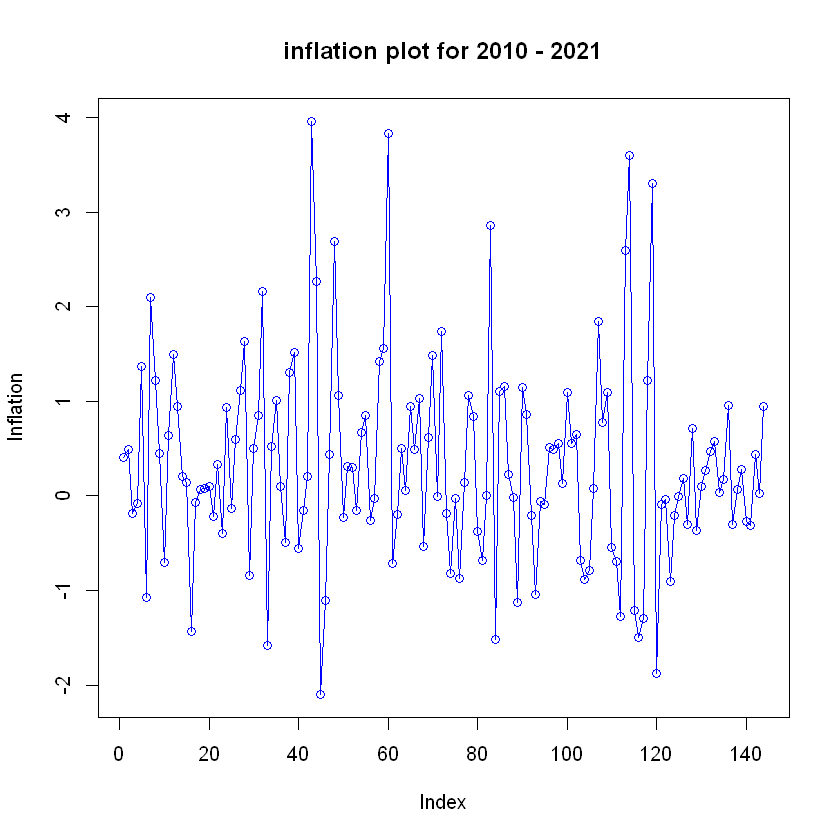

In [9]:
## Plot of Inflation
plot(data$Inflasi,type = "o", col = "blue", xlab = "Index", ylab = 'Inflation',
   main = "inflation plot for 2010 - 2021")

In [10]:
head(data[order(-data$Inflasi), ], 5)

Bulan,Tahun,Inflasi
<chr>,<chr>,<dbl>
Juli,2013,3.96
Desember,2014,3.83
Juni,2019,3.60
November,2019,3.30
November,2016,2.86


__From the plot, it can be seen that the inflation value continues to rise and fall every month. The inflation value which rises significantly in the plot shows that in these months, whether Muslims celebrate Eid al-Fitr or Christians celebrate Christmas, which causes the prices of goods and services to also rise.__

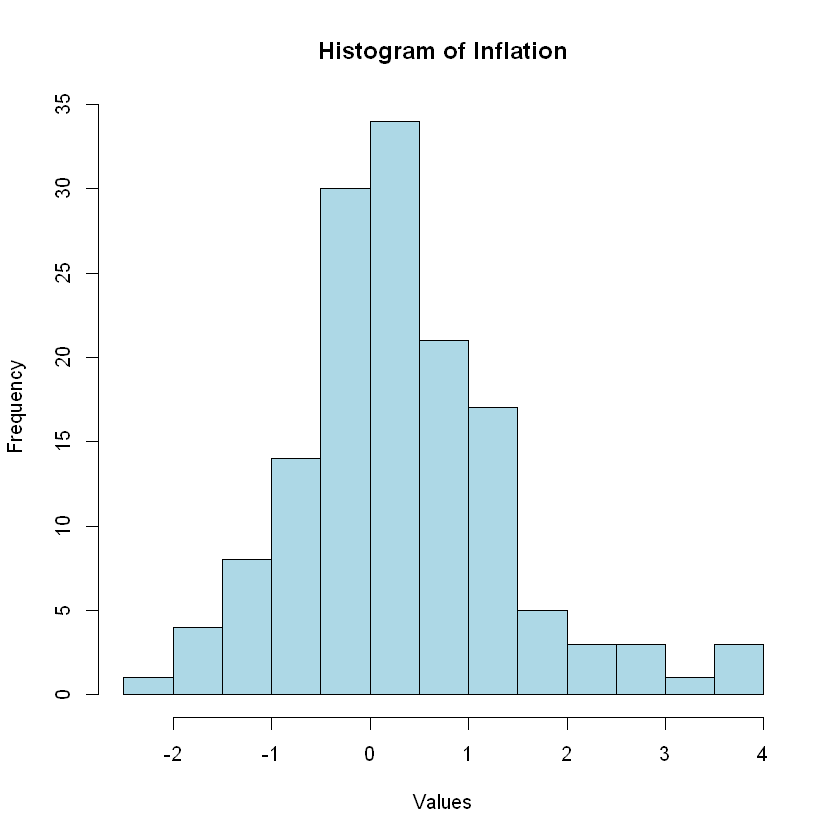

In [11]:
## Histogram
hist(data$Inflasi, 
     main = "Histogram of Inflation",  
     xlab = "Values",                   
     ylab = "Frequency",                
     col = "lightblue",                 
     border = "black") 

__we can see from the histogram, the data we have follows a normal distribution, with most of the data spread over the range of values -1 and 1__

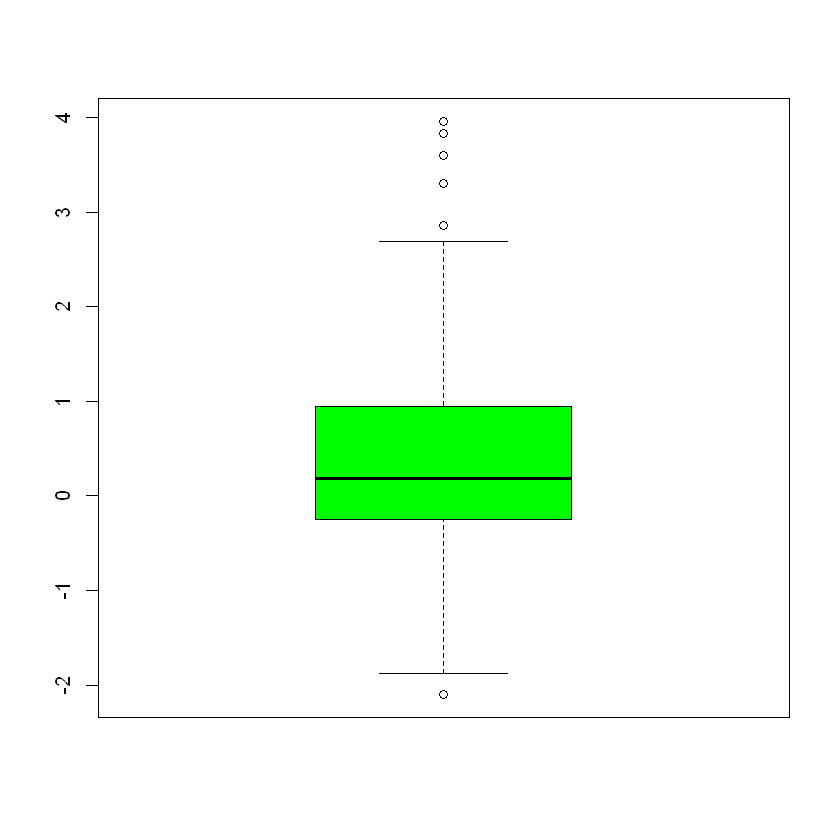

In [12]:
## Boxplot
boxplot(data$Inflasi,col='green')

__from the box plot we can see,we have some oulier in it__

## 4. Feature Engginering

### Divide Data Base On PACF
### What is PACF ?
__PACF stands for "Partial AutoCorrelation Function," and it is a statistical tool used in time series analysis and forecasting. The PACF is a way to investigate the relationship between a data point and its lagged values while controlling for the influence of other lags__

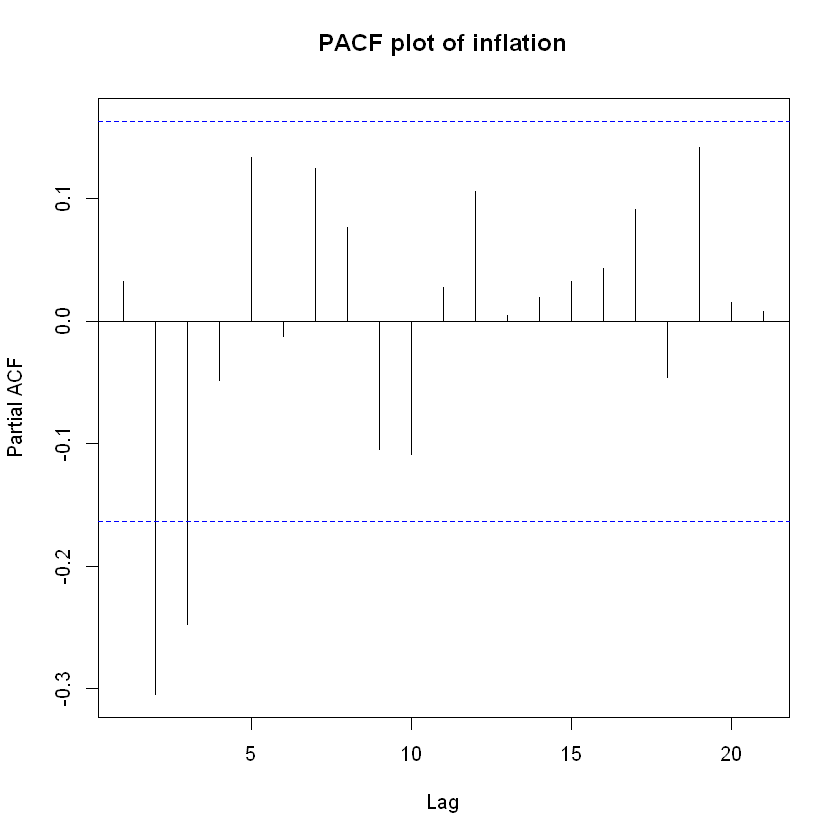

In [13]:
pacf(data$Inflasi, main='PACF plot of inflation')

__from the pacf plot, lag 2 and lag 3 are significant lags(past value), This means that the current inflation value is influenced by the inflation value two periods before and the value three periods before__

In [14]:
## Output Feature
Y <- data$Inflasi[4:length(data$Inflasi)]

In [15]:
## Input Feature
lag_2 <- data$Inflasi[2:142]
lag_3 <- data$Inflasi[1:141]

In [16]:
## create dataframe for input and output
data <- data.frame(lag_3=lag_3, lag_2=lag_2, Y=Y)

In [17]:
## check top 6 observation
head(data)

,lag_3,lag_2,Y
,<dbl>,<dbl>,<dbl>
1,0.41,0.49,-0.08
2,0.49,-0.18,1.37
3,-0.18,-0.08,-1.07
4,-0.08,1.37,2.10
5,1.37,-1.07,1.22
6,-1.07,2.10,0.45


### Split Data Into Train and Test

In [18]:
set.seed(123)
index <- createDataPartition(data$Y, p = 0.8, list = FALSE)
train_data <- data[index, ]
test_data <- data[-index, ]

In [19]:
X_train <- train_data[,c('lag_3','lag_2')]
head(X_train)
Y_train <- train_data[,'Y']
head(Y_train)

,lag_3,lag_2
,<dbl>,<dbl>
1,0.41,0.49
3,-0.18,-0.08
4,-0.08,1.37
5,1.37,-1.07
10,-0.70,0.64
11,0.64,1.50


[1] -0.08 -1.07  2.10  1.22  0.95  0.21

In [20]:
dim(train_data)
dim(test_data)

[1] 114   3

[1] 27  3

### Feature Scaling
__I Will Use Min-Max Scaling__

In [21]:
## Define the column names want to scale
column_names <- c("lag_2", "lag_3")

## Loop through each column name and scale the corresponding columns in train_data and test_data
for (col_name in column_names) {
  train_data[, col_name] <- (train_data[, col_name] - min(train_data[, col_name])) / (max(train_data[, col_name]) - min(train_data[, col_name]))
  test_data[, col_name] <- (test_data[, col_name] - min(test_data[, col_name])) / (max(test_data[, col_name]) - min(test_data[, col_name]))
}


In [22]:
head(train_data)

,lag_3,lag_2,Y
,<dbl>,<dbl>,<dbl>
1,0.4141914,0.4273927,-0.08
3,0.3168317,0.3333333,-1.07
4,0.3333333,0.5726073,2.10
5,0.5726073,0.1699670,1.22
10,0.2310231,0.4521452,0.95
11,0.4521452,0.5940594,0.21


In [23]:
head(test_data)

,lag_3,lag_2,Y
,<dbl>,<dbl>,<dbl>
2,0.5527778,0.2183236,1.37
6,0.1194444,0.6627680,0.45
7,1.0000000,0.4912281,-0.70
8,0.7555556,0.3411306,0.64
9,0.5416667,0.1169591,1.50
14,0.4750000,0.2807018,-0.07


## 5.Model Training

In [24]:
## SVR with default parameter
## default kernel = radial
## cost = 1
## gamma = 0.5
## epsilon = 0.1

svr_model <- svm(Y ~ ., data = train_data, kernel = "radial",type='eps-regression')

## use deafult svr model to preict training and testing data
predictions_train <- predict(svr_model, newdata = train_data[,c('lag_3','lag_2')])
predictions_test <- predict(svr_model, newdata = test_data[,c('lag_3','lag_2')])

In [25]:
## Model Evaluation 
mse_train <- MSE(predictions_train, train_data$Y)
mse_test <- MSE(predictions_test, test_data$Y)
cat('MSE Train :',mse_train, '\n')
cat('MSE Test  :',mse_test)

MSE Train : 0.887864 
MSE Test  : 0.6975887

__The MSE train and test scores have similar values and mse value in the test data also decreased it show the model work good with unseen data__

## 6. Hyperparameter Tuning SVR

In [26]:
## Hyperparameter Tuning in SVR using Grid Search 

# Define the range of hyperparameters for the grid search
cost_range <- 2^(0:9)
epsilon_range <- 2^(-9:0)
gamma_range <- 2^(0:9)

# Define the tuning control parameters using the tune.control function
tuning_control <- tune.control(sampling = "cross",  # Cross-validation
                               cross = 10)   # Number of folds for cross-validation

In [27]:
set.seed(123)  # Set a specific random seed

# Perform the grid search for hyperparameter tuning with the radial kernel
tune_radial <- tune.svm(Y ~ ., 
                        data = train_data,
                        kernel = "radial",
                        cost = cost_range,
                        epsilon = epsilon_range,
                        gamma = gamma_range,
                        tunecontrol = tuning_control)

In [28]:
tune_radial


Parameter tuning of 'svm':

- sampling method: 10-fold cross validation 

- best parameters:
 gamma cost epsilon
     4    1    0.25

- best performance: 1.131919 


In [29]:
best_model_rbf <- tune_radial$best.model

In [31]:
## use best model with hyperparameter tuning in train and test data
predictions_train <- predict(best_model_rbf, train_data[,c('lag_3','lag_2')] )
predictions_test <- predict(best_model_rbf, test_data[,c('lag_3','lag_2')] )

radial_mse_train <- MSE(predictions_train, train_data$Y)
radial_mse_test <- MSE(predictions_test, test_data$Y)

cat('MSE Train use best model radial :',mse_train, '\n')
cat('MSE Test use best model radial  :',mse_test)



MSE Train use best model radial : 0.887864 
MSE Test use best model radial  : 0.847235

__The rmse value of the model shows a value close to 0, which indicates that the model is good for prediction__

## 7. Make Prediction

__we want to predict inflation for December, we also know the inflation data for the previous months, the inflation values for the last three months and two months are used as input variables and predict inflation for December, let's say September inflation = 0.45 and October inflation = 0.18, then prediction for December is__

In [35]:
input_data <- data.frame(lag_3 = 0.45, lag_2 = 0.18)
december_inflation <- predict(best_model_rbf, input_data)
cat('December Inflation is :', december_inflation)

December Inflation is : -0.2020691

In [43]:
# Save the SVR model to the Kaggle output directory
saveRDS(best_model_rbf, file.path("./Model/", "svr_model_radial.rds"))